# Monte Carlo visualization sandbox

Configured for remote Jupyter access on Graham

***

In [19]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, cm, colors
from cmocean import cm as cmo
from datetime import datetime
from glob import glob
from tqdm.notebook import tqdm

%matplotlib inline

In [20]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 12})

***

### Process Monte Carlo

Parameters

In [5]:
# Results path
results_path = '/scratch/dlatorne/MIDOSS/runs/monte-carlo'

# Slicing and plotting params
zlevel = 39
jmin, jmax = 400, 800
imin, imax = 110, 350

# Slicing and plotting variables
x, y = np.arange(imin, imax), np.arange(jmin, jmax)
slc = {'grid_z': zlevel, 'grid_y': slice(jmin, jmax), 'grid_x': slice(imin, imax)}

# NEMO meshmask
mask = xr.open_dataset('/home/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
tmask = mask.tmask[0, 0, jmin:jmax, imin:imax]

Run sets

In [34]:
# Define runset lists
runsets = [
    'northern_strait_first30',
    'north_strait_2nd60',
    'north_strait_3rd150',
    'north_strait_4th122',
    'north_strait_5th362',
]

timestamps = [
    '2021-06-11T202428',
    '2021-06-12T141330',
    '2021-06-12T201317',
    '2021-06-13T143859',
    '2021-06-14T150753',
]

nruns = [30, 60, 150, 122, 362]

Load data into dict of lists

In [ ]:
# Collect individual runs across all run sets
Results = {'Date': [], 'OilType': []}
Results['Surface'] = {days: [] for days in range(1, 8)}
for runset, timestamp, n in zip(runsets, timestamps, nruns):
    for run in tqdm(range(n)):
        
        # Exclude hdf5 datasets
        if (runset == 'north_strait_5th362') & (run > 268): break
        
        # Construct path and load into Xarray Dataset
        runpath = f'{results_path}/{runset}_{timestamp}/results/{runset}-{run}'
        oiltype = glob(f'{runpath}/Lagrangian*')[0].split('/')[-1].split('_')[1].split('-')[0]
        fn = f'{runpath}/Lagrangian_{oiltype}-{run}_{runset}-{run}.nc'
        with xr.open_dataset(fn) as ds:
            
            # Append results to lists
            data = ds.OilWaterColumnOilVol_3D.isel(slc).values
            Results['Date'].append(ds.time[0].values.astype('datetime64[s]').astype(datetime))
            Results['OilType'].append(oiltype)
            for days in range(1, 8):
                Results['Surface'][days].append(data[:int(days * 24), ...].sum(axis=0))

In [ ]:
# Preserve as netcdf
data = np.concatenate([np.concatenate([data[None, ...] for data in Results['Surface'][days]])[None, ...] for days in range(1, 8)]) 
ds = xr.Dataset(
    {
        'OilWaterColumnOilVol_surface': (['days', 'date', 'y', 'x'], data),
        'OilType': ('date', np.array(Results['OilType'])),
    },
    coords={'days': np.arange(1, 8), 'date': np.array(Results['Date']), 'y': y, 'x': x},
)
ds.to_netcdf('/scratch/bmoorema/Results/MIDOSS_aggregated.nc')

***

### Visualization

Plot PDF

In [7]:
ds = xr.open_dataset('/scratch/bmoorema/Results/MIDOSS_aggregated.nc')
OilType = ds.OilType.values

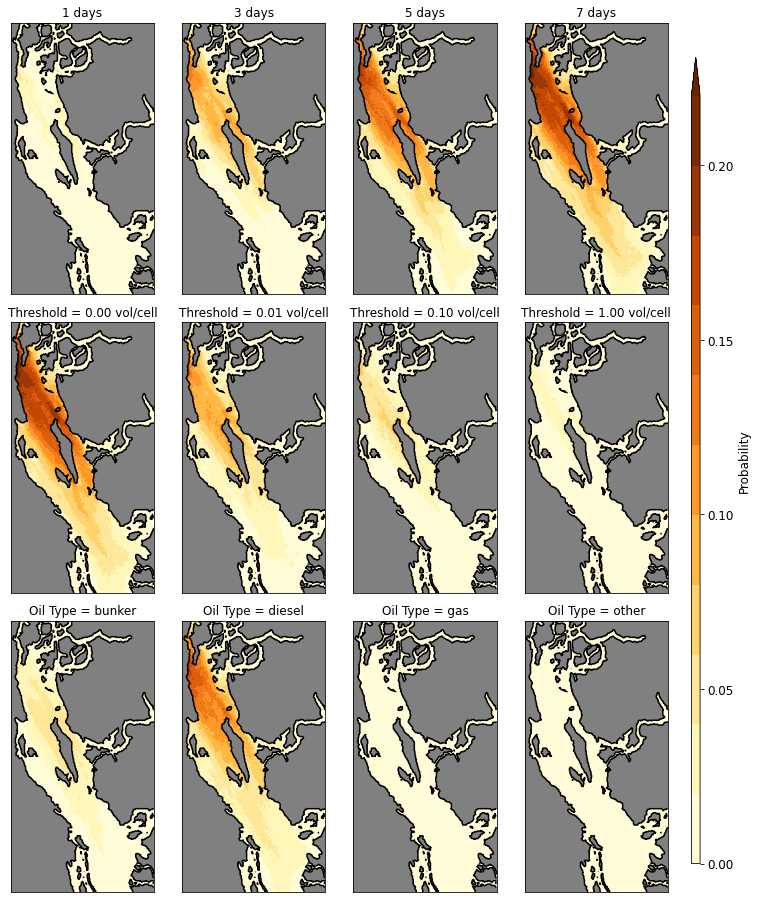

In [39]:
# Plot PDF
fig, axs = plt.subplots(3, 4, figsize=(12, 16), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
    
for ax, days in zip(axs[0, :], range(1, 8, 2)):

    PDF = ds.OilWaterColumnOilVol_surface.sel(days=days).values.astype(bool).mean(axis=0)
    c = ax.contourf(x+0.75, y+0.75, PDF, levels=np.arange(0, 0.221, 0.02), cmap='YlOrBr', extend='max')
    ax.set_title(f'{days} days')

for ax, threshold in zip(axs[1, :], [0, 0.01, 0.1, 1]):
    
    PDF = (ds.OilWaterColumnOilVol_surface.sel(days=7).values > threshold).astype(bool).mean(axis=0)
    c = ax.contourf(x+0.75, y+0.75, PDF, levels=np.arange(0, 0.221, 0.02), cmap='YlOrBr', extend='max')
    ax.set_title(f'Threshold = {threshold:.2f} vol/cell')

for ax, oiltype in zip(axs[2, :], ['bunker', 'diesel', 'gas', 'other']):
    
    index = OilType == oiltype
    PDF = ds.OilWaterColumnOilVol_surface.sel(days=7).values[index, ...].astype(bool).sum(axis=0) / len(index)
    c = ax.contourf(x+0.75, y+0.75, PDF, levels=np.arange(0, 0.221, 0.02), cmap='YlOrBr', extend='max')
    ax.set_title(f'Oil Type = {oiltype}')
    
for ax in axs.ravel():
    ax.contourf(x, y, tmask, levels=[-0.01, 0.01], colors='Gray')
    ax.contour(x, y, tmask, levels=[-0.01, 0.01], colors='k')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect(5/4.4)
        
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, ticks=np.arange(0, 0.21, 0.05), label='Probability')
#fig.savefig('/home/bmoorema/MEOPAR/midoss-visualization/figures/presence_matrix.png', bbox_inches='tight')

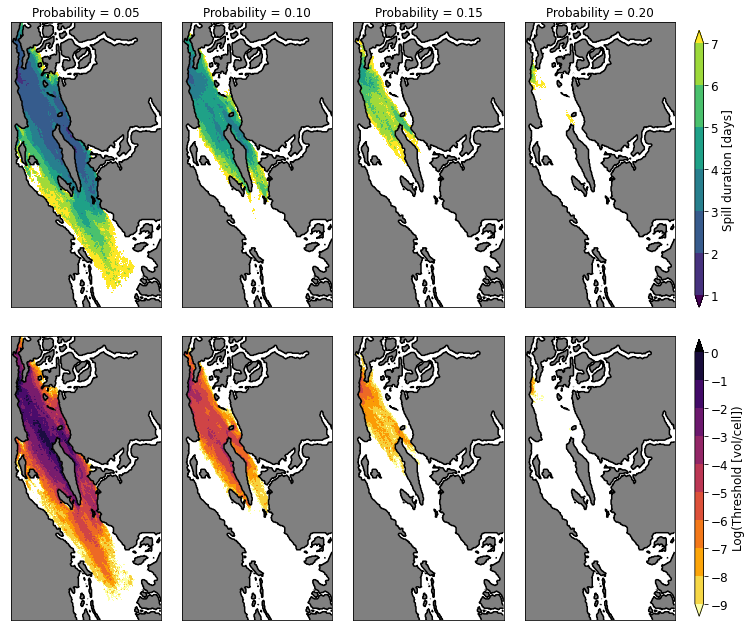

In [98]:
# Plot PDF
fig, axs = plt.subplots(2, 4, figsize=(12, 11), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

cmap = plt.get_cmap('viridis')
for days in range(7, 0, -1):
    PDF = ds.OilWaterColumnOilVol_surface.sel(days=days).values.astype(bool).mean(axis=0)
    for ax, probability in zip(axs[0, :], np.arange(0.05, 0.21, 0.05)):
        ax.contourf(x+0.75, y+0.75, PDF, levels=[probability-0.01, probability+0.01], colors=[cmap(days/7)], extend='max')
        ax.set_title(f'Probability = {probability:.2f}')
norm = colors.BoundaryNorm(range(1, 8), cmap.N, extend='both')
cax1 = fig.add_axes([0.92, 0.52, 0.01, 0.35])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax1, label='Spill duration [days]')

cmap = plt.get_cmap('inferno')
for LogThreshold in range(-9, 1):
    PDF = (ds.OilWaterColumnOilVol_surface.sel(days=7).values > np.exp(LogThreshold)).astype(bool).mean(axis=0)
    for ax, probability in zip(axs[1, :], np.arange(0.05, 0.21, 0.05)):
        ax.contourf(x+0.75, y+0.75, PDF, levels=[probability-0.01, probability+0.01], colors=[cmap(abs(LogThreshold)/9)], extend='max')
cmap = plt.get_cmap('inferno_r')
norm = colors.BoundaryNorm(range(-9, 1), cmap.N, extend='both')
cax2 = fig.add_axes([0.92, 0.13, 0.01, 0.35])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax2, label='Log(Threshold [vol/cell])')

for ax in axs.ravel():
    ax.contourf(x, y, tmask, levels=[-0.01, 0.01], colors='Gray')
    ax.contour(x, y, tmask, levels=[-0.01, 0.01], colors='k')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect(5/4.4)
#fig.savefig('/home/bmoorema/MEOPAR/midoss-visualization/figures/presence_matrix_transposed.png', bbox_inches='tight')

<ipython-input-73-f3a7025caf0f>:22: UserWarning: Log scale: values of z <= 0 have been masked
  c = col[0].contourf(x+0.75, y+0.75, data.sum(axis=0), levels=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], cmap='inferno', norm=colors.LogNorm(), extend='max')
<ipython-input-73-f3a7025caf0f>:22: UserWarning: Log scale: values of z <= 0 have been masked
  c = col[0].contourf(x+0.75, y+0.75, data.sum(axis=0), levels=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], cmap='inferno', norm=colors.LogNorm(), extend='max')
<ipython-input-73-f3a7025caf0f>:22: UserWarning: Log scale: values of z <= 0 have been masked
  c = col[0].contourf(x+0.75, y+0.75, data.sum(axis=0), levels=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], cmap='inferno', norm=colors.LogNorm(), extend='max')
<ipython-input-73-f3a7025caf0f>:22: UserWarning: Log scale: values of z <= 0 have been masked
  c = col[0].contourf(x+0.75, y+0.75, data.sum(axis=0), levels=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], cmap='inferno', norm=colors.LogNorm(), extend='max')
<ipython-input-73-f3

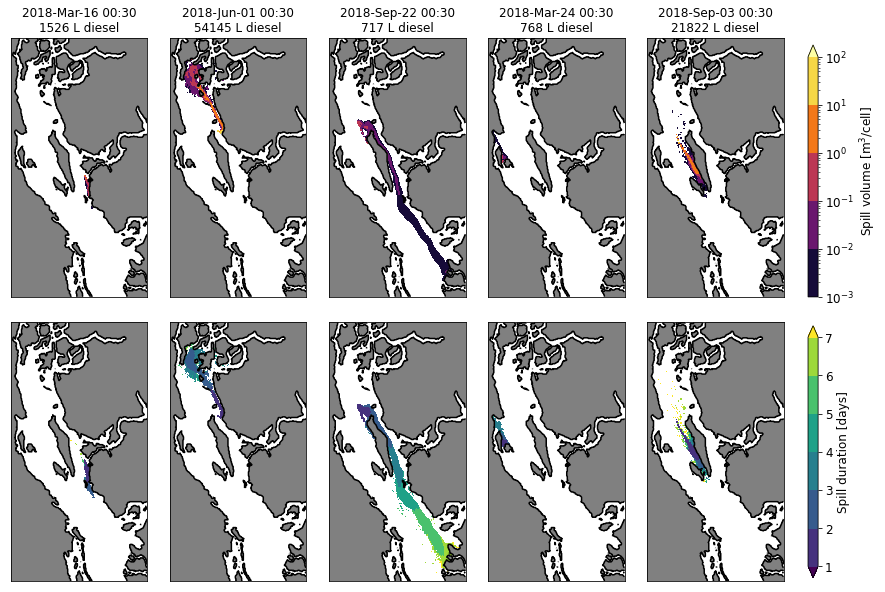

In [73]:
runset = 'northern_strait_first30'
timestamp = '2021-06-11T202428'
n = 30

# Plot PDF
fig, axs = plt.subplots(2, 5, figsize=(14, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

cmap = plt.get_cmap('viridis')
for col, run in zip(axs.T, range(5)):
    
    runpath = f'{results_path}/{runset}_{timestamp}/results/{runset}-{run}'
    oiltype = glob(f'{runpath}/Lagrangian*')[0].split('/')[-1].split('_')[1].split('-')[0]
    fn = f'{runpath}/Lagrangian_{oiltype}-{run}_{runset}-{run}.nc'
    with xr.open_dataset(fn) as ds:
        data = ds.OilWaterColumnOilVol_3D.isel(slc).values
        
    # Parse date and volume spill
    date = ds.time[0].values.astype('datetime64[s]').astype(datetime).strftime('%Y-%b-%d %H:%M')
    vol = ds.OilWaterColumnOilVol_3D[1, ...].max().values*1e3
    
    # Plot concentration
    c = col[0].contourf(x+0.75, y+0.75, data.sum(axis=0), levels=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], cmap='inferno', norm=colors.LogNorm(), extend='max')
    col[0].set_title(f'{date}\n{vol:.0f} L {oiltype}')
    
    # Plot daily P/A
    for days in range(7, 0, -1):
        PDF = data[:int(days*24)].sum(axis=0).astype(bool)
        col[1].contourf(x+0.75, y+0.75, ~PDF, levels=[-0.01, 0.01], colors=[cmap(days/7)])
    
    for ax in col:
        ax.contourf(x, y, tmask, levels=[-0.01, 0.01], colors='Gray')
        ax.contour(x, y, tmask, levels=[-0.01, 0.01], colors='k')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_aspect(5/4.4)


cax1 = fig.add_axes([0.92, 0.52, 0.01, 0.35])
fig.colorbar(c, cax=cax1, label='Spill volume [m$^3$/cell]')

norm = colors.BoundaryNorm(range(1, 8), cmap.N, extend='both')
cax2 = fig.add_axes([0.92, 0.13, 0.01, 0.35])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax2, label='Spill duration [days]')
fig.savefig('/home/bmoorema/MEOPAR/midoss-visualization/figures/single_spills.png', bbox_inches='tight')